<a href="https://colab.research.google.com/github/Rezwan66/Sentiment_Analysis-Project/blob/main/Sentiment_Analysis_of_student's_chats_in_SQLvalidator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import re
import string

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download("stopwords")
from gensim.test.utils import common_dictionary, common_corpus

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
import itertools
from wordcloud import WordCloud,ImageColorGenerator,STOPWORDS
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Sentiment():

  stop=set(stopwords.words("english"))
  target_label_name=["Neutral","Positive"]
  target_category_name=["Troubleshooting","Collaborative"]


  def __init__(self,test):
    self.test=test
    input_test=pd.read_excel(test)
    self.df=pd.DataFrame(input_test)
    self.df.dropna(inplace=True)
    #print(self.df.head(2))
    #print(f"len of Dataframe index - {len(self.df.index)}")    


  def head(self,quantity):
   print(self.df.head(quantity))


  def label_encoder(self):
    encoder=LabelEncoder()
    self.df["new_label"]=self.df["label"].apply(lambda x: 1 if x=="positive" else 0) #encoder.fit_transform(df["label"])
    self.df["new_category"]=self.df["Category"].apply(lambda x: 1 if x=="collaborative" else 0 )
    #print(self.df.head(5))  


  def pre_processing(self,size_1=.2,state_1=30,size_2=0.2,state_2=30):
    self.df["pre_process"] = self.df["Updated post"].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
    self.df["pre_process"]=self.df["pre_process"].apply(lambda x: " ".join([re.sub("[^A-Za-z]+"," ", x) for x in nltk.word_tokenize(x)]))
    self.df["pre_process"]=self.df["pre_process"].apply(lambda x: " ".join([x for x in x.split() if x not in self.stop]))
    self.df["pre_process"]=self.df["pre_process"].map(lambda x: re.sub(r'http://\S+|https://\S+',"",x))
    self.df.dropna(subset=["pre_process"],inplace=True)


    self.X_train,self.X_test,self.Y_train,self.Y_test = train_test_split(self.df["pre_process"], self.df["new_label"], test_size=size_1, random_state=state_1)
    vectorizer_label=TfidfVectorizer()  #use tfidf vectorizer methods or printout the shape of vectorizer
    self.tf_x_train = vectorizer_label.fit_transform(self.X_train)
    self.tf_x_test = vectorizer_label.transform(self.X_test) 

    self.X1_train,self.X1_test,self.Y1_train, self.Y1_test = train_test_split(self.df["pre_process"], self.df["new_category"], test_size=size_1, random_state=state_1)
    vectorizer_category=TfidfVectorizer()
    self.tf_x1_train = vectorizer_category.fit_transform(self.X1_train)
    self.tf_x1_test = vectorizer_category.transform(self.X1_test)

    words = " ".join(v for v in self.df["pre_process"])
    stop=set(STOPWORDS)
    stop = stop.union(["customers","students","insert","hi","varchar","create","table","primary", "null","foreign", "key","select","int","id","references","customer","product","name","supplier","student"])
    wordcloud = WordCloud(stopwords=stop,background_color='white',colormap="inferno", max_font_size = 30, max_words = 1000).generate(words)
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation= 'spline36')
    plt.axis('off')
    plt.show()
    
    fig, ax = plt.subplots()
    self.df['new_label'].value_counts().plot(ax=ax, kind='bar', xlabel='0=Neutral   1=Positive', ylabel='Frequency')
    plt.show()
    fig1, ax1 = plt.subplots()
    self.df['new_category'].value_counts().plot(ax=ax1, kind='bar', xlabel='0=Troubleshooting   1=Collaborative', ylabel='Frequency')
    plt.show()

    print(f'Total number of samples {len(self.df)}')

  
  def svm(self,p_1="l1",c_1=1.4,l_1='squared_hinge',p_2="l1",c_2=0.8,l_2='squared_hinge',d=False,state=0):
    
    # Linear SVM for "label" column
    self.svm_model_label=LinearSVC(penalty=p_1,C=c_1,loss=l_1,dual=d,random_state=state)     
    self.svm_model_label.fit(self.tf_x_train,self.Y_train)
    y_test_pred=self.svm_model_label.predict(self.tf_x_test)

    # Linear SVM for "Category" column
    self.svm_model_category=LinearSVC(penalty=p_2,C=c_2,loss=l_2,dual=d,random_state=state)
    self.svm_model_category.fit(self.tf_x1_train,self.Y1_train)
    y1_test_pred=self.svm_model_category.predict(self.tf_x1_test)

    # error measurement
    report_svm_label=classification_report(self.Y_test, y_test_pred,output_dict=False,target_names=self.target_label_name)   # "output_dict=False" will convert the output of into dictionary instead of table
    report_svm_category=classification_report(self.Y1_test, y1_test_pred,output_dict=False,target_names=self.target_category_name)
    
    self.report_1=classification_report(self.Y_test, y_test_pred,output_dict=True,target_names=self.target_label_name)
    self.report_1.update({"accuracy": {"precision": None, "recall": None, "f1-score": self.report_1["accuracy"], "support": None}})
    self.report_1=pd.DataFrame(self.report_1).transpose()
    self.report_2=classification_report(self.Y1_test, y1_test_pred,output_dict=True,target_names=self.target_category_name)
    self.report_2.update({"accuracy": {"precision": None, "recall": None, "f1-score": self.report_2["accuracy"], "support": None}})
    self.report_2=pd.DataFrame(self.report_2).transpose()


    ConfusionMatrixDisplay.from_predictions(self.Y_test,y_test_pred,cmap="plasma")
    plt.show()  
    print(f"\nValidation matrix of Label column for SVM\n{report_svm_label}\n")
    ConfusionMatrixDisplay.from_predictions(self.Y1_test,y1_test_pred,cmap="plasma")
    plt.show()
    print(f"\nValidation matrix of Category column for SVM\n{report_svm_category}\n")
    

  def multi_NB(self,a_1=0.8,fp_1=False,cp_1=[.9,.3],a_2=0.5,fp_2=False,cp_2=[.3,.85]):
    
    # Multinomial Naive Bayes for "label" column
    self.mnb_model_label=MultinomialNB(alpha=a_1,fit_prior=fp_1,class_prior=cp_1)
    self.mnb_model_label.fit(self.tf_x_train,self.Y_train)
    y_test_predict=self.mnb_model_label.predict(self.tf_x_test)

    # Multinomial Naive Bayes for "Category" column
    self.mnb_model_category=MultinomialNB(alpha=a_2,fit_prior=fp_2,class_prior=cp_2)
    self.mnb_model_category.fit(self.tf_x1_train,self.Y1_train)
    y1_test_predict=self.mnb_model_category.predict(self.tf_x1_test)

    # Error measurement
    report_mnb_label=classification_report(self.Y_test,y_test_predict,output_dict=False,target_names=self.target_label_name)
    report_mnb_category=classification_report(self.Y1_test,y1_test_predict,output_dict=False,target_names=self.target_category_name)

    self.report_3=classification_report(self.Y_test,y_test_predict,output_dict=True,target_names=self.target_label_name)
    self.report_3.update({"accuracy": {"precision": None, "recall": None, "f1-score": self.report_3["accuracy"], "support": None}})
    self.report_3=pd.DataFrame(self.report_3).transpose()
    self.report_4=classification_report(self.Y1_test,y1_test_predict,output_dict=True,target_names=self.target_category_name)
    self.report_4.update({"accuracy": {"precision": None, "recall": None, "f1-score": self.report_4["accuracy"], "support": None}})
    self.report_4=pd.DataFrame(self.report_4).transpose()
    
    ConfusionMatrixDisplay.from_predictions(self.Y_test,y_test_predict,cmap="plasma")
    plt.show()
    print(f"\nValidation matrix of Label column Multinomial Naive Bayes\n{report_mnb_label}\n")
    ConfusionMatrixDisplay.from_predictions(self.Y1_test,y1_test_predict,cmap="plasma")
    plt.show()
    print(f"\nValidation matrix of Category column for Multinomial Naive Bayes\n{report_mnb_category}\n")


  def comp_NB(self,a_1=1.7,fp_1=False,cp_1=[.4,.8],a_2=1,fp_2=False,cp_2=[.1,.5]):

    # Complement Naive Bayes for "label" column
    self.cnb_model_label=ComplementNB(alpha=a_1,fit_prior=fp_1,class_prior=cp_1)
    self.cnb_model_label.fit(self.tf_x_train,self.Y_train)
    y_test_predict=self.cnb_model_label.predict(self.tf_x_test)

    # Complement Naive Bayes for "Category" column
    self.cnb_model_category=ComplementNB(alpha=a_2,fit_prior=fp_2,class_prior=cp_2)
    self.cnb_model_category.fit(self.tf_x1_train,self.Y1_train)
    y1_test_predict=self.cnb_model_category.predict(self.tf_x1_test)

    # Error measurement
    report_cnb_label=classification_report(self.Y_test,y_test_predict,output_dict=False,target_names=self.target_label_name)
    report_cnb_category=classification_report(self.Y1_test,y1_test_predict,output_dict=False,target_names=self.target_category_name)
    
    self.report_5= classification_report(self.Y_test,y_test_predict,output_dict=True,target_names=self.target_label_name)
    self.report_5.update({"accuracy": {"precision": None, "recall": None, "f1-score": self.report_5["accuracy"], "support": None}})
    self.report_5=pd.DataFrame(self.report_5).transpose()
    self.report_6=classification_report(self.Y1_test,y1_test_predict,output_dict=True,target_names=self.target_category_name)
    self.report_6.update({"accuracy": {"precision": None, "recall": None, "f1-score": self.report_6["accuracy"], "support": None}})
    self.report_6=pd.DataFrame(self.report_6).transpose() 

    ConfusionMatrixDisplay.from_predictions(self.Y_test,y_test_predict,cmap="plasma")
    plt.show()
    print(f"\nValidation matrix of Label column for Complement Naive Bayes \n{report_cnb_label}\n")
    ConfusionMatrixDisplay.from_predictions(self.Y1_test,y1_test_predict,cmap="plasma")
    plt.show()
    print(f"\nValidation matrix of Category column for Complement Naive Bayes \n{report_cnb_category}\n")
    

  def export_to_xl(self,existing_file_path):
    with pd.ExcelWriter(existing_file_path,mode="a", engine="openpyxl",if_sheet_exists="replace") as ex:
      self.report_1.to_excel(ex,sheet_name="SVM_label",startcol=2)   
      self.report_2.to_excel(ex,sheet_name="SVM_category",startcol=2)
      self.report_3.to_excel(ex,sheet_name="MNB_label",startcol=2)
      self.report_4.to_excel(ex,sheet_name="MNB_category",startcol=2)
      self.report_5.to_excel(ex,sheet_name="CNB_label",startcol=2)
      self.report_6.to_excel(ex,sheet_name="CNB_category",startcol=2)


In [ ]:
newr=Sentiment(r'/content/drive/MyDrive/SQL Project Team 2_Summer 2022/data/chats_data.xlsx')  #path of labelled dataset


In [ ]:
newr.label_encoder()


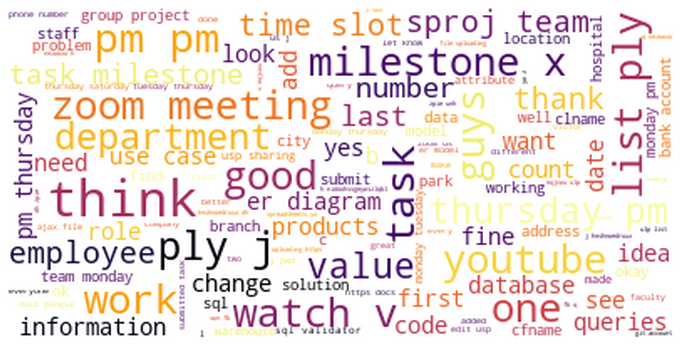

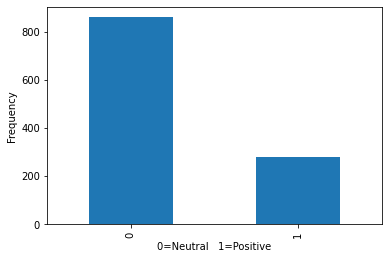

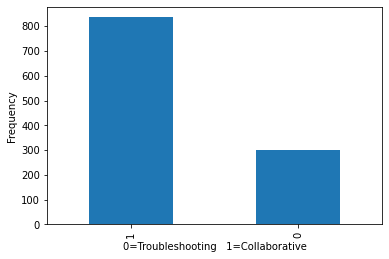

Total number of samples 1138


In [ ]:
newr.pre_processing()

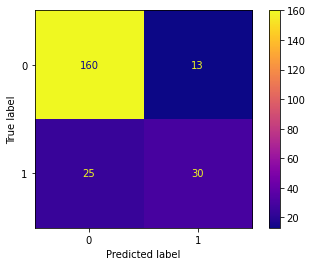


Validation matrix of Label column for SVM
              precision    recall  f1-score   support

     Neutral       0.86      0.92      0.89       173
    Positive       0.70      0.55      0.61        55

    accuracy                           0.83       228
   macro avg       0.78      0.74      0.75       228
weighted avg       0.82      0.83      0.83       228




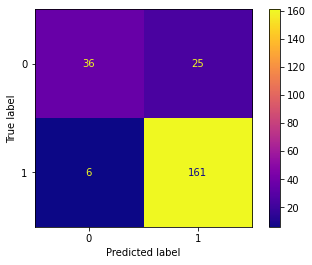


Validation matrix of Category column for SVM
                 precision    recall  f1-score   support

Troubleshooting       0.86      0.59      0.70        61
  Collaborative       0.87      0.96      0.91       167

       accuracy                           0.86       228
      macro avg       0.86      0.78      0.81       228
   weighted avg       0.86      0.86      0.86       228




In [ ]:
newr.svm()

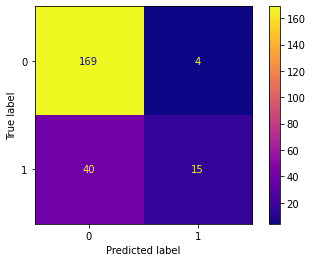


Validation matrix of Label column Multinomial Naive Bayes
              precision    recall  f1-score   support

     Neutral       0.81      0.98      0.88       173
    Positive       0.79      0.27      0.41        55

    accuracy                           0.81       228
   macro avg       0.80      0.62      0.65       228
weighted avg       0.80      0.81      0.77       228




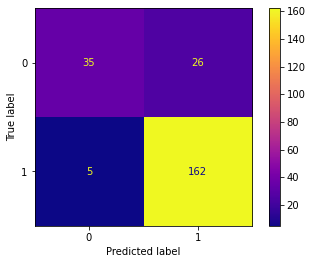


Validation matrix of Category column for Multinomial Naive Bayes
                 precision    recall  f1-score   support

Troubleshooting       0.88      0.57      0.69        61
  Collaborative       0.86      0.97      0.91       167

       accuracy                           0.86       228
      macro avg       0.87      0.77      0.80       228
   weighted avg       0.87      0.86      0.85       228




In [ ]:
newr.multi_NB()

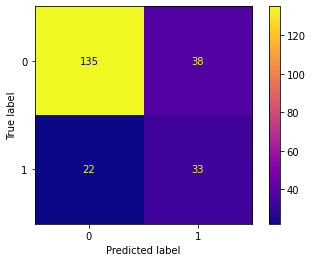


Validation matrix of Label column for Complement Naive Bayes 
              precision    recall  f1-score   support

     Neutral       0.86      0.78      0.82       173
    Positive       0.46      0.60      0.52        55

    accuracy                           0.74       228
   macro avg       0.66      0.69      0.67       228
weighted avg       0.76      0.74      0.75       228




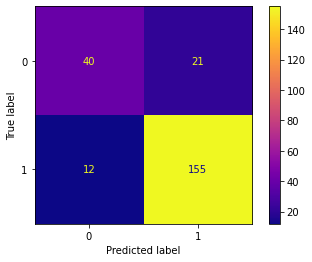


Validation matrix of Category column for Complement Naive Bayes 
                 precision    recall  f1-score   support

Troubleshooting       0.77      0.66      0.71        61
  Collaborative       0.88      0.93      0.90       167

       accuracy                           0.86       228
      macro avg       0.82      0.79      0.81       228
   weighted avg       0.85      0.86      0.85       228




In [ ]:
newr.comp_NB()

In [ ]:
newr.export_to_xl(r'/content/drive/MyDrive/SQL Project Team 2_Summer 2022/data/chats_data.xlsx') #path for existing dataset file to store the output
